# NLP with oil and renewable energies project

#### Get libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


## Creating month weights

In [2]:
corpus_oil_price=pd.read_csv("data/corpus_oil_price.csv", index_col=0)
corpus_alternative_energies=pd.read_csv("data/corpus_alternative_energies.csv", index_col=0)
corpus_crude_oil=pd.read_csv("data/corpus_crude_oil.csv", index_col=0)

In [3]:
corpus_oil_price["date_published"] = pd.to_datetime(corpus_oil_price["date_published"], utc=True)
corpus_alternative_energies["date_published"] = pd.to_datetime(corpus_alternative_energies["date_published"], utc=True)
corpus_crude_oil["date_published"] = pd.to_datetime(corpus_crude_oil["date_published"], utc=True)
corpus_crude_oil


,Unnamed: 0.1,title,date_published,content,baseline_sentiment,vader_sentiment
0,0,Oil Bulls Rejoice As Biden's Supply Strategy B...,2021-11-25 00:00:00+00:00,President Biden&rsquo;s threat to oil producer...,-1,-0.9926
1,1,"OPEC To Add 400,000 Bpd In January Despite Oil...",2021-12-02 14:53:55+00:00,The OPEC group is sticking to its plan to ease...,0,0.4497
2,2,UAE Pumps $6 Billion Into Oil And Gas Expansio...,2021-11-24 23:00:00+00:00,The U.S.-sponsored &lsquo;relationship normali...,1,0.9875
3,3,China Keeps Markets In The Dark About SPR Release,2021-11-24 22:00:00+00:00,The volume of the expected Chinese release of ...,-1,-0.9552
4,4,Oil Markets Unimpressed By Small Crude Invento...,2021-11-24 15:36:00+00:00,"Crude oil inventories rose last week, while ga...",-1,-0.9601
...,...,...,...,...,...,...
5000,5000,A Detailed Guide on the Many Different Types o...,2009-12-02 23:12:01+00:00,Some people arbitrarily speak about oil as if ...,-1,-0.9962
5001,5001,What is Peak Oil Theory A Thorough Look at Thi...,2009-10-21 21:17:44+00:00,Currently there is a lot of debate going on re...,1,-0.1567
5002,5002,Oil Shale - So Just What Is It,2009-09-24 22:26:55+00:00,People often say &ldquo;You can&rsquo;t squeez...,-1,0.9816
5003,5003,Oil is not a Villain Here's what it's done for us,2009-09-21 21:45:02+00:00,"For decades now, oil has often been vilified a...",1,0.9987


In [4]:
corpus_oil_price_resampled = corpus_oil_price.resample('M', on='date_published').mean()
corpus_alternative_energies_resampled = corpus_alternative_energies.resample('M', on='date_published').mean()
corpus_crude_oil_resampled = corpus_crude_oil.resample('M', on='date_published').mean()

In [5]:
corpus_oil_price_resampled.index = pd.to_datetime(corpus_oil_price_resampled.index).strftime('%Y-%m')
corpus_alternative_energies_resampled.index = pd.to_datetime(corpus_alternative_energies_resampled.index).strftime('%Y-%m')
corpus_crude_oil_resampled.index = pd.to_datetime(corpus_crude_oil_resampled.index).strftime('%Y-%m')
corpus_crude_oil_resampled

,Unnamed: 0.1,baseline_sentiment,vader_sentiment
date_published,,,
2009-07,5004.000000,-1.000000,-0.987900
2009-08,NaN,NaN,NaN
2009-09,5002.500000,0.000000,0.990150
2009-10,5001.000000,1.000000,-0.156700
2009-11,NaN,NaN,NaN
...,...,...,...
2021-08,227.863636,-0.090909,0.196308
2021-09,153.280000,-0.120000,0.031880
2021-10,88.098039,-0.098039,0.201992


### Regression with oil prices

In [6]:
corpus_oil_price_resampled

,baseline_sentiment,vader_sentiment
date_published,,
2009-11,1.000000,0.998550
2009-12,-1.000000,0.098200
2010-01,0.000000,0.128680
2010-02,0.000000,0.567283
2010-03,0.111111,0.848289
...,...,...
2021-08,-0.560000,-0.545292
2021-09,-0.250000,-0.237639
2021-10,-0.476190,-0.447929


In [7]:
corpus_oil_price_resampled.isna().sum()

baseline_sentiment    4
vader_sentiment       4
dtype: int64

In [8]:
is_NaN = corpus_oil_price_resampled.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = corpus_oil_price_resampled[row_has_NaN]
rows_with_NaN

,baseline_sentiment,vader_sentiment
date_published,,
2012-11,NaN,NaN
2013-05,NaN,NaN
2013-07,NaN,NaN
2014-01,NaN,NaN


In [9]:
corpus_oil_price_resampled.index = pd.to_datetime(corpus_oil_price_resampled.index)
corpus_oil_price_resampled['vader_sentiment'].interpolate(method='polynomial', order=2, inplace=True)

In [10]:
is_NaN = corpus_oil_price_resampled.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = corpus_oil_price_resampled[row_has_NaN]
rows_with_NaN

,baseline_sentiment,vader_sentiment
date_published,,
2012-11-01,NaN,-0.399684
2013-05-01,NaN,0.977149
2013-07-01,NaN,0.123677
2014-01-01,NaN,0.422792


In [11]:
corpus_oil_price_resampled.to_csv('data/corpus_oil_price_resampled2.csv')
corpus_oil_price_resampled

,baseline_sentiment,vader_sentiment
date_published,,
2009-11-01,1.000000,0.998550
2009-12-01,-1.000000,0.098200
2010-01-01,0.000000,0.128680
2010-02-01,0.000000,0.567283
2010-03-01,0.111111,0.848289
...,...,...
2021-08-01,-0.560000,-0.545292
2021-09-01,-0.250000,-0.237639
2021-10-01,-0.476190,-0.447929


In [12]:
corpus_oil_price_resampled=pd.read_csv("data/corpus_oil_price_resampled2.csv", index_col=0)

In [13]:
oil_price=pd.read_csv("data/oil_prices.csv", index_col=0)
oil_price

,Brent,oil_production,oil_consumption,interaction_term
date_published,,,,
2009-11-01,76.66,5561.0,18753.0,104285433.0
2009-12-01,74.46,5512.0,19237.0,106034344.0
2010-01-01,76.17,5403.0,18649.0,100760547.0
2010-02-01,73.75,5510.0,18831.0,103758810.0
2010-03-01,78.83,5489.0,19080.0,104730120.0
...,...,...,...,...
2021-08-01,70.75,11500.0,20511.0,235876500.0
2021-09-01,74.49,11100.0,20224.0,224486400.0
2021-10-01,83.54,11500.0,NaN,NaN


In [14]:
corpus_oil_price_resampled2 = corpus_oil_price_resampled.merge(oil_price, on="date_published")
corpus_oil_price_resampled2.drop(columns=['baseline_sentiment'])

,vader_sentiment,Brent,oil_production,oil_consumption,interaction_term
date_published,,,,,
2009-11-01,0.998550,76.66,5561.0,18753.0,104285433.0
2009-12-01,0.098200,74.46,5512.0,19237.0,106034344.0
2010-01-01,0.128680,76.17,5403.0,18649.0,100760547.0
2010-02-01,0.567283,73.75,5510.0,18831.0,103758810.0
2010-03-01,0.848289,78.83,5489.0,19080.0,104730120.0
...,...,...,...,...,...
2021-08-01,-0.545292,70.75,11500.0,20511.0,235876500.0
2021-09-01,-0.237639,74.49,11100.0,20224.0,224486400.0
2021-10-01,-0.447929,83.54,11500.0,NaN,NaN


In [15]:
corpus_oil_price_resampled2.drop(corpus_oil_price_resampled2.tail(3).index,inplace=True)
corpus_oil_price_resampled2

,baseline_sentiment,vader_sentiment,Brent,oil_production,oil_consumption,interaction_term
date_published,,,,,,
2009-11-01,1.000000,0.998550,76.66,5561.0,18753.0,104285433.0
2009-12-01,-1.000000,0.098200,74.46,5512.0,19237.0,106034344.0
2010-01-01,0.000000,0.128680,76.17,5403.0,18649.0,100760547.0
2010-02-01,0.000000,0.567283,73.75,5510.0,18831.0,103758810.0
2010-03-01,0.111111,0.848289,78.83,5489.0,19080.0,104730120.0
...,...,...,...,...,...,...
2021-05-01,-0.411765,0.019765,68.53,10800.0,20094.0,217015200.0
2021-06-01,0.190476,0.074110,73.16,11100.0,20537.0,227960700.0
2021-07-01,-0.677419,-0.319545,75.17,11200.0,19894.0,222812800.0


<AxesSubplot:xlabel='date_published'>

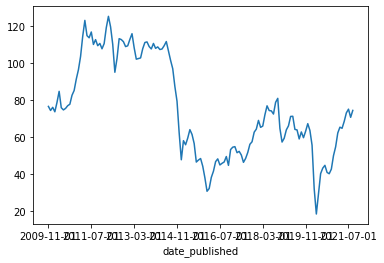

In [16]:
corpus_oil_price_resampled2.Brent.plot()

In [17]:
corpus_oil_price_resampled2['Brent-1'] = corpus_oil_price_resampled2['Brent'].shift(1)
corpus_oil_price_resampled2['vader_sentiment-1'] = corpus_oil_price_resampled2['vader_sentiment'].shift(1)
corpus_oil_price_resampled2

,baseline_sentiment,vader_sentiment,Brent,oil_production,oil_consumption,interaction_term,Brent-1,vader_sentiment-1
date_published,,,,,,,,
2009-11-01,1.000000,0.998550,76.66,5561.0,18753.0,104285433.0,NaN,NaN
2009-12-01,-1.000000,0.098200,74.46,5512.0,19237.0,106034344.0,76.66,0.998550
2010-01-01,0.000000,0.128680,76.17,5403.0,18649.0,100760547.0,74.46,0.098200
2010-02-01,0.000000,0.567283,73.75,5510.0,18831.0,103758810.0,76.17,0.128680
2010-03-01,0.111111,0.848289,78.83,5489.0,19080.0,104730120.0,73.75,0.567283
...,...,...,...,...,...,...,...,...
2021-05-01,-0.411765,0.019765,68.53,10800.0,20094.0,217015200.0,64.81,-0.051500
2021-06-01,0.190476,0.074110,73.16,11100.0,20537.0,227960700.0,68.53,0.019765
2021-07-01,-0.677419,-0.319545,75.17,11200.0,19894.0,222812800.0,73.16,0.074110


In [18]:
corpus_oil_price_resampled2.drop(index='2009-11-01', columns='baseline_sentiment')

,vader_sentiment,Brent,oil_production,oil_consumption,interaction_term,Brent-1,vader_sentiment-1
date_published,,,,,,,
2009-12-01,0.098200,74.46,5512.0,19237.0,106034344.0,76.66,0.998550
2010-01-01,0.128680,76.17,5403.0,18649.0,100760547.0,74.46,0.098200
2010-02-01,0.567283,73.75,5510.0,18831.0,103758810.0,76.17,0.128680
2010-03-01,0.848289,78.83,5489.0,19080.0,104730120.0,73.75,0.567283
2010-04-01,0.104390,84.82,5522.0,19066.0,105282452.0,78.83,0.848289
...,...,...,...,...,...,...,...
2021-05-01,0.019765,68.53,10800.0,20094.0,217015200.0,64.81,-0.051500
2021-06-01,0.074110,73.16,11100.0,20537.0,227960700.0,68.53,0.019765
2021-07-01,-0.319545,75.17,11200.0,19894.0,222812800.0,73.16,0.074110


### Separating data

In [32]:
corpus_oil_price_resampled2.dropna(inplace=True)

X = corpus_oil_price_resampled2[['vader_sentiment-1', 'interaction_term']]
y = corpus_oil_price_resampled2['Brent']

In [33]:
train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [34]:
parameters = {'n_estimators': [50, 100, 200], 'max_depth': [2, 10, 15, 50,100]}
random_forest = RandomForestRegressor(random_state= 42) 
cv = GridSearchCV(random_forest, param_grid = parameters, verbose=10)
rf_model = cv.fit(X_train, y_train)   

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 1/5; 1/15] END max_depth=2, n_estimators=50;, score=-1.550 total time=   0.0s
[CV 2/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 2/5; 1/15] END max_depth=2, n_estimators=50;, score=-4.686 total time=   0.0s
[CV 3/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 3/5; 1/15] END max_depth=2, n_estimators=50;, score=0.203 total time=   0.1s
[CV 4/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 4/5; 1/15] END max_depth=2, n_estimators=50;, score=-19.412 total time=   0.1s
[CV 5/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 5/5; 1/15] END max_depth=2, n_estimators=50;, score=-3.316 total time=   0.1s
[CV 1/5; 2/15] START max_depth=2, n_estimators=100..............................
[CV 1/5; 2/15] END max_depth=2, n_estimator

[CV 1/5; 11/15] END max_depth=50, n_estimators=100;, score=-1.539 total time=   0.2s
[CV 2/5; 11/15] START max_depth=50, n_estimators=100............................
[CV 2/5; 11/15] END max_depth=50, n_estimators=100;, score=-8.151 total time=   0.2s
[CV 3/5; 11/15] START max_depth=50, n_estimators=100............................
[CV 3/5; 11/15] END max_depth=50, n_estimators=100;, score=0.149 total time=   0.2s
[CV 4/5; 11/15] START max_depth=50, n_estimators=100............................
[CV 4/5; 11/15] END max_depth=50, n_estimators=100;, score=-16.884 total time=   0.2s
[CV 5/5; 11/15] START max_depth=50, n_estimators=100............................
[CV 5/5; 11/15] END max_depth=50, n_estimators=100;, score=-3.313 total time=   0.2s
[CV 1/5; 12/15] START max_depth=50, n_estimators=200............................
[CV 1/5; 12/15] END max_depth=50, n_estimators=200;, score=-1.513 total time=   0.5s
[CV 2/5; 12/15] START max_depth=50, n_estimators=200............................
[CV 

In [35]:
size = int(0.85 * corpus_oil_price_resampled2.shape[0])
corpus_oil_price_resampled2_2 = corpus_oil_price_resampled2[size:]
corpus_oil_price_resampled2_2

,baseline_sentiment,vader_sentiment,Brent,oil_production,oil_consumption,interaction_term,Brent-1,vader_sentiment-1
date_published,,,,,,,,
2020-01-01,-0.764706,-0.537024,63.65,12900.0,19933.0,257135700.0,67.31,0.011007
2020-02-01,-0.941176,-0.763759,55.66,13100.0,20132.0,263729200.0,63.65,-0.537024
2020-03-01,-0.777778,-0.435022,32.01,13000.0,18463.0,240019000.0,55.66,-0.763759
2020-04-01,-0.583333,-0.644442,18.38,12100.0,14549.0,176042900.0,32.01,-0.435022
2020-05-01,-0.032258,-0.406752,29.38,11200.0,16078.0,180073600.0,18.38,-0.644442
2020-06-01,-0.166667,-0.485146,40.27,11000.0,17578.0,193358000.0,29.38,-0.406752
2020-07-01,-0.312500,-0.604912,43.24,11000.0,18381.0,202191000.0,40.27,-0.485146
2020-08-01,-0.400000,-0.157020,44.74,9700.0,18558.0,180012600.0,43.24,-0.604912
2020-09-01,0.090909,-0.378650,40.91,10700.0,18415.0,197040500.0,44.74,-0.157020


In [36]:
y_pred = rf_model.predict(X_test)

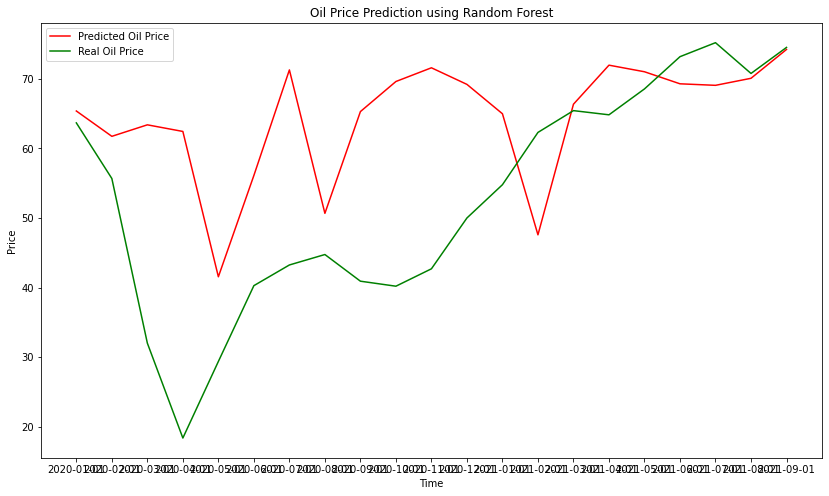

In [37]:
plt.figure(figsize=(14,8))
plt.plot(y_pred, color = 'red', label = 'Predicted Oil Price')
plt.plot(corpus_oil_price_resampled2_2.Brent, color = 'green', label = 'Real Oil Price')
plt.title('Oil Price Prediction using Random Forest')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### Regression with renewable energies

In [ ]:
corpus_alternative_energies_resampled

In [ ]:
corpus_alternative_energies_resampled.isna().sum()

In [ ]:
corpus_alternative_energies_resampled.index = pd.to_datetime(corpus_alternative_energies_resampled.index)
corpus_alternative_energies_resampled['vader_sentiment'].interpolate(method='polynomial', order=2, inplace=True)

In [ ]:
is_NaN = corpus_alternative_energies_resampled.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = corpus_alternative_energies_resampled[row_has_NaN]
rows_with_NaN

In [ ]:
corpus_alternative_energies_resampled.to_csv('data/corpus_alternative_energies_resampled2.csv')
corpus_alternative_energies_resampled

In [ ]:
corpus_alternative_energies_resampled=pd.read_csv("data/corpus_alternative_energies_resampled2.csv", index_col=0)

In [ ]:
renewables=pd.read_csv("data/renewable_energy_consumption.csv", index_col=0)
renewables.dropna(inplace=True)
renewables

In [ ]:
corpus_alternative_energies_resampled2 = corpus_alternative_energies_resampled.merge(renewables, on="date_published")
corpus_alternative_energies_resampled2

In [ ]:
corpus_alternative_energies_resampled2['Total_renewable_consumption-1'] = corpus_alternative_energies_resampled2['Total_renewable_consumption'].shift(1)
corpus_alternative_energies_resampled2

In [ ]:
corpus_alternative_energies_resampled2.drop(index='2009-11-01', columns=['baseline_sentiment', 'Unnamed: 0.1'])

### Separating data

In [ ]:
corpus_alternative_energies_resampled2.dropna(inplace=True)

X = corpus_alternative_energies_resampled2[['vader_sentiment', 'Industrial_Production_Index']]
y = corpus_alternative_energies_resampled2['Total_renewable_consumption']

In [ ]:
train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [ ]:
rf_model = RandomForestRegressor()

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
size = int(0.85 * corpus_alternative_energies_resampled2.shape[0])
corpus_alternative_energies_resampled2 = corpus_alternative_energies_resampled2[size:]
corpus_alternative_energies_resampled2

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(y_pred, color = 'red', label = 'Predicted Renewable Energy Consumption')
plt.plot(corpus_alternative_energies_resampled2['Total_renewable_consumption'], color = 'green', label = 'Observed Renewable Energy Consumption')
plt.title('Renewable Energy Demand Prediction using Random Forest')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()